In [ ]:
!pip install torchvision

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

# Define transforms for data preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize images to range [-1, 1]
])

# Download CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Create data loaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

# Define class labels
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D, Concatenate, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint

# Load CIFAR-10 dataset
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

# Preprocessing
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(train_images)

# GoogLeNet model
def inception_module(x, filters):
    branch1x1 = Conv2D(filters[0], (1, 1), padding='same', activation='relu')(x)

    branch3x3 = Conv2D(filters[1], (1, 1), padding='same', activation='relu')(x)
    branch3x3 = Conv2D(filters[2], (3, 3), padding='same', activation='relu')(branch3x3)

    branch5x5 = Conv2D(filters[3], (1, 1), padding='same', activation='relu')(x)
    branch5x5 = Conv2D(filters[4], (5, 5), padding='same', activation='relu')(branch5x5)

    branch_pool = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    branch_pool = Conv2D(filters[5], (1, 1), padding='same', activation='relu')(branch_pool)

    output = Concatenate(axis=-1)([branch1x1, branch3x3, branch5x5, branch_pool])
    return output

input_layer = Input(shape=(32, 32, 3))
x = Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu')(input_layer)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = Conv2D(64, (1, 1), padding='same', activation='relu')(x)
x = Conv2D(192, (3, 3), padding='same', activation='relu')(x)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

x = inception_module(x, [64, 96, 128, 16, 32, 32])
x = inception_module(x, [128, 128, 192, 32, 96, 64])
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = inception_module(x, [192, 96, 208, 16, 48, 64])

# Add more inception modules as needed...

# Redefine model after the last inception module
x = AveragePooling2D((2, 2), strides=(1, 1), padding='valid')(x)
x = Dropout(0.4)(x)
x = Flatten()(x)
output_layer = Dense(10, activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output_layer)


# Compile model
model.compile(optimizer=SGD(lr=0.01, momentum=0.9), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Define model checkpoint callback
checkpoint = ModelCheckpoint("googlenet_cifar10.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Train the model
epochs = 50
batch_size = 128
history = model.fit(datagen.flow(train_images, train_labels, batch_size=batch_size),
                    steps_per_epoch=len(train_images) / batch_size, epochs=epochs,
                    validation_data=(test_images, test_labels),
                    callbacks=[checkpoint])

# Print epoch and accuracy after each training epoch
for epoch, acc in enumerate(history.history['accuracy']):
    print(f"Epoch {epoch+1}: Accuracy = {acc}")


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d_21 (Conv2D)          (None, 16, 16, 64)           9472      ['input_2[0][0]']             
                                                                                                  
 max_pooling2d_6 (MaxPoolin  (None, 8, 8, 64)             0         ['conv2d_21[0][0]']           
 g2D)                                                                                             
                                                                                                  
 conv2d_22 (Conv2D)          (None, 8, 8, 64)             4160      ['max_pooling2d_6[0][0]'] 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/50
391/390 [==============================] - ETA: 0s - loss: 1.7219 - accuracy: 0.0946
Epoch 2: val_accuracy did not improve from 0.09560
390/390 [==============================] - 29s 74ms/step - loss: 1.7219 - accuracy: 0.0946 - val_loss: 1.5023 - val_accuracy: 0.0675
Epoch 3/50
391/390 [==============================] - ETA: 0s - loss: 1.5236 - accuracy: 0.0960
Epoch 3: val_accuracy did not improve from 0.09560
390/390 [==============================] - 28s 72ms/step - loss: 1.5236 - accuracy: 0.0960 - val_loss: 1.4101 - val_accuracy: 0.0891
Epoch 4/50
391/390 [==============================] - ETA: 0s - loss: 1.4091 - accuracy: 0.0962
Epoch 4: val_accuracy did not improve from 0.09560
390/390 [==============================] - 30s 76ms/step - loss: 1.4091 - accuracy: 0.0962 - val_loss: 1.2846 - val_accuracy: 0.0871
Epoch 5/50
391/390 [==============================] - ETA: 0s - loss: 1.3132 - accuracy: 0.0957
Epoch 5: val_accuracy improved from 0.09560 to 0.09980, saving m

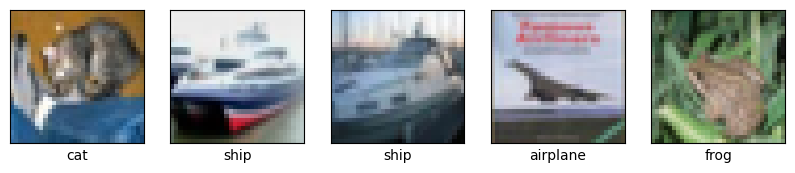

In [ ]:
import matplotlib.pyplot as plt

# Printing some trained images
def plot_images(images, labels, class_names, num_images=5):
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i][0]])
    plt.show()




# Plotting some images
plot_images(test_images, test_labels, class_names=["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"])


